Building the repository citation graph...
Graph has 1120 nodes and 1006 edges.


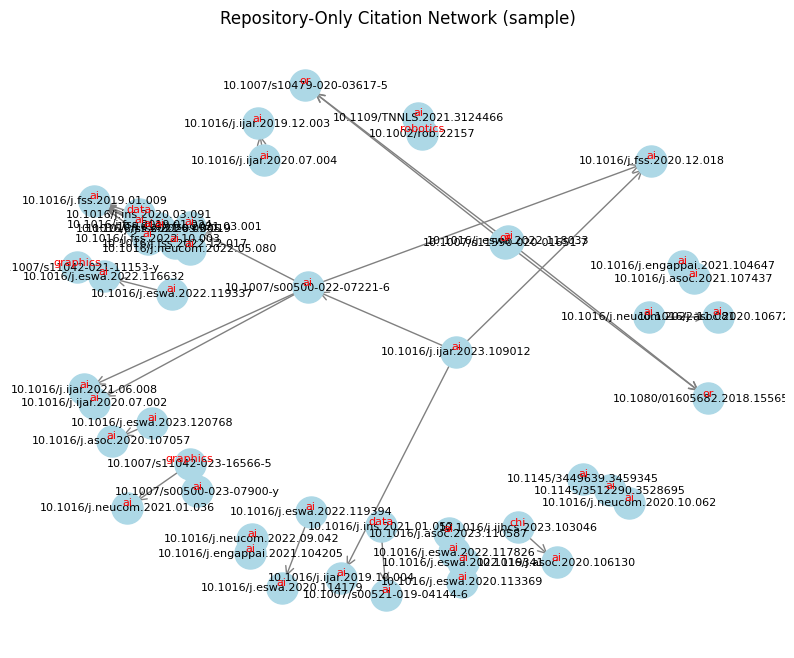

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def build_repo_graph(csv_file: str) -> nx.DiGraph:
    """
    Build a directed graph from the citation edge list CSV.
    
    The CSV is expected to have four columns:
      - origin_doi, origin_sub_area, target_doi, target_sub_area
      
    For each node (publication DOI), the sub_area attribute is taken
    from the available information (either from origin_sub_area or target_sub_area).
    
    Parameters:
        csv_file (str): Path to the CSV file with the edge list.
        
    Returns:
        nx.DiGraph: A directed NetworkX graph with nodes annotated with 'sub_area'.
    """
    # Load the edge list from CSV
    df = pd.read_csv(csv_file)
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Build a mapping from DOI to its sub-area from both origin and target columns.
    # (Assuming that if a node appears as origin, its sub_area is in origin_sub_area,
    # and if as target then in target_sub_area.)
    node_subarea = {}
    for _, row in df.iterrows():
        origin_doi = row["origin_doi"]
        target_doi = row["target_doi"]
        origin_sub = row["origin_sub_area"] if pd.notna(row["origin_sub_area"]) else None
        target_sub = row["target_sub_area"] if pd.notna(row["target_sub_area"]) else None
        
        # Update origin DOI sub-area if not yet set (or if available, you could decide on a priority)
        if origin_doi not in node_subarea:
            node_subarea[origin_doi] = origin_sub or target_sub
        # In case the DOI already exists but has no sub-area and we now have one.
        elif node_subarea[origin_doi] is None and (origin_sub or target_sub):
            node_subarea[origin_doi] = origin_sub or target_sub
        
        if target_doi not in node_subarea:
            node_subarea[target_doi] = target_sub or origin_sub
        elif node_subarea[target_doi] is None and (target_sub or origin_sub):
            node_subarea[target_doi] = target_sub or origin_sub

    # Add all nodes to the graph with the attribute "sub_area"
    for doi, sub_area in node_subarea.items():
        G.add_node(doi, sub_area=sub_area)
    
    # Add edges from the DataFrame
    for _, row in df.iterrows():
        G.add_edge(row["origin_doi"], row["target_doi"])
    
    return G

def draw_graph(G: nx.DiGraph, sample_size: int = 50):
    """
    Draw a sample of the graph using matplotlib.
    
    For large graphs, we sample up to `sample_size` nodes to avoid a cluttered drawing.
    
    Parameters:
        G (nx.DiGraph): The graph to draw.
        sample_size (int): The maximum number of nodes to draw.
    """
    # For large graphs, take a subgraph
    if G.number_of_nodes() > sample_size:
        nodes = list(G.nodes())[:sample_size]
        H = G.subgraph(nodes)
    else:
        H = G
        
    pos = nx.spring_layout(H, seed=42)
    plt.figure(figsize=(10, 8))
    
    # Draw nodes and edges
    nx.draw_networkx_nodes(H, pos, node_size=500, node_color="lightblue")
    nx.draw_networkx_edges(H, pos, arrowstyle='->', arrowsize=15, edge_color="gray")
    nx.draw_networkx_labels(H, pos, font_size=8)
    
    # Prepare node attribute labels (sub_area) for display (optional)
    subarea_labels = {n: f"{d.get('sub_area', 'N/A')}" for n, d in H.nodes(data=True)}
    # Draw sub-area labels in red next to the nodes.
    nx.draw_networkx_labels(H, pos, labels=subarea_labels, font_color="red", font_size=8, verticalalignment='bottom')
    
    plt.title("Repository-Only Citation Network (sample)")
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    # Path to the CSV file produced in the previous steps.
    csv_file = "citations_edge_list_repo_only.csv"
    
    print("Building the repository citation graph...")
    G = build_repo_graph(csv_file)
    print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    
    # Draw a sample of the graph.
    draw_graph(G, sample_size=50)
